In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy.stats import binned_statistic_2d


current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
DF_PATH = os.path.join(ROOT_PATH, "data", "df_5s_avg.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [3]:
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-11-30-16-50-2ax_noise_route_test")
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-11-30-22-24-2p_2ax_noise_route_test")
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\7-2024-10-09-22-34-2ax_route_abci")
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2025-01-14-12-43-test_hidde_harf")
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2025-01-15-14-23-dummy_spot_pos")


cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [4]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [5]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [6]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

In [7]:

ut.fix_seeds(0)
df = pickle.load(open(DF_PATH, "rb"))
config = conf.from_yaml(config_path)
# config = conf.from_yaml(r"C:\Users\hal\Documents\lab\abci\config\config.yaml")
# df = pickle.load(open(config["df_name"], "rb"))

# 各種初期化
model = models.get_model_with_checkpoint(config["model"], cp_path)
route_gen = routes.get_route_generator(config["route"])
dataset = datasets.get_dataset(config["dataset"])
dm = datamodules.get_dm(config["dm"])

dataset.set_route(df, route_gen)
dm.setDataset(dataset)

# train_dataset = datasets.RouteDatasetWithRoute(6400)
# val_dataset = datasets.RouteDatasetWithRoute(1600)
# test_dataset = datasets.RouteDatasetWithRoute(2000)

# train_dataset.set_route(df, route_gen)
# val_dataset.set_route(df, route_gen)
# test_dataset.set_route(df, route_gen)

# dataset = [
#     train_dataset, val_dataset, test_dataset
# ]
df


,x,y,MF,MF_X,MF_Y,MF_Z
0,0,0,47.092824,15.922708,-24.282148,-37.075312
1,1,0,47.006834,15.718135,-25.290383,-36.323777
2,2,0,46.904898,15.512466,-26.195008,-35.626671
3,3,0,46.771071,15.304602,-26.892416,-35.038420
4,4,0,46.589408,15.093445,-27.278996,-34.613452
...,...,...,...,...,...,...
3126,26,100,38.792002,3.686721,-19.262970,-33.319910
3127,27,100,38.170764,2.066179,-19.227704,-32.627471
3128,28,100,37.575150,0.115492,-19.140441,-31.999105
3129,29,100,36.996618,-2.055291,-19.018515,-31.413456


Cache not found. Set cache.
x 

c:\Users\hal\Documents\lab\abci\env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


tensor([[[6., 6., 6., 6.],
         [0., 0., 0., 1.],
         [0., 0., 0., 2.],
         [0., 0., 0., 3.],
         [0., 0., 0., 4.],
         [0., 0., 0., 5.],
         [0., 0., 0., 6.],
         [0., 0., 0., 7.],
         [0., 0., 0., 8.],
         [0., 0., 0., 9.]]], device='cuda:0')
y tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [6., 6.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]], device='cuda:0')
y_hat tensor([[[-0.0255, -0.0255],
         [-0.0225, -0.0225],
         [-0.0224, -0.0224],
         [-0.0225, -0.0225],
         [-0.0226, -0.0226],
         [-0.0281, -0.0281],
         [ 6.1014,  6.1014],
         [-0.0298, -0.0298],
         [-0.0304, -0.0304],
         [-0.0333, -0.0333]]], device='cuda:0', grad_fn=<ViewBackward0>)
x tensor([[[1., 1., 1., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 2.],
         [0., 0., 0., 3.],
         [0., 0., 0., 4.],
         [0., 0., 0., 5

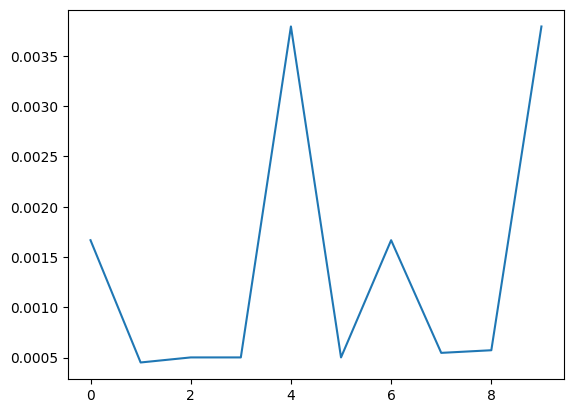

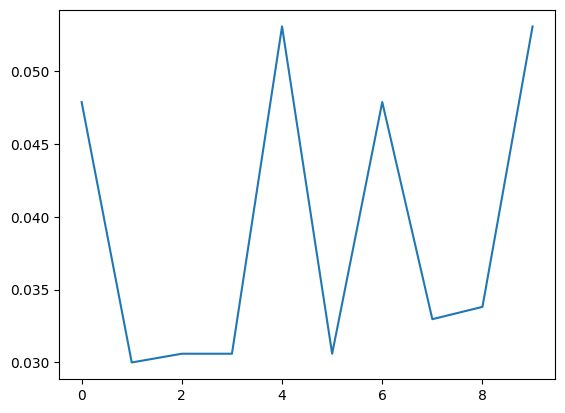

0.0013997646485222504


In [8]:


model.eval()


loss_list = []
dist_list = []

# 累積データ用のリスト
all_y = []
all_errors = []


# for i in range(len(dm.train_dataset)):
for i in range(10):
    # batch = dm.train_dataset[i]
    # batch = dm.val_dataset[i]
    batch = dm.test_dataset[i]

    x, y = batch
    x = x.unsqueeze(0).cuda()
    y = y.unsqueeze(0).cuda()

    # mean = 0.0  # 平均
    # std = 0.381  # 標準偏差
    # x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    # x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    # x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

    
    y_hat = model(x)

    print("x", x)
    print("y", y)
    print("y_hat", y_hat)


    loss = nn.functional.mse_loss(y_hat, y)
    loss_list.append(loss.item())

    # print(loss.item())

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    # plot_route2(x, y, y_hat)
    # plot_route(y, y_hat)

    dist_errors = np.linalg.norm(y - y_hat, axis=-1)
    all_y.append(y)
    all_errors.append(dist_errors)

    dist_mean = np.mean(dist_errors)

    
    dist_list.append(dist_mean)  
    # print(dist_mean)
    

# 全データを結合
all_y = np.concatenate(all_y, axis=1)  # (1, 全座標数, 2)
all_errors = np.concatenate(all_errors, axis=1)  # (1, 全座標数)

# XとYの範囲を指定（0.1刻み）
x_bins = np.arange(0, 3.1, 0.1)  # 0から3まで0.1刻み
y_bins = np.arange(0, 10.1, 0.1)  # 0から10まで0.1刻み

# 2次元ヒートマップデータを作成
heatmap, x_edges, y_edges, _ = binned_statistic_2d(
    all_y[0, :, 0],  # x座標
    all_y[0, :, 1],  # y座標
    all_errors[0],   # 値（誤差）
    statistic='mean',  # 各グリッド内での値の集計方法（平均）
    bins=[x_bins, y_bins]
)

# ヒートマップの描画
# plt.figure(figsize=(8, 12))
# plt.imshow(
#     np.flipud(heatmap.T),  # Y軸を反転
#     extent=[x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()],
#     cmap='Reds',
#     aspect='auto',
#     origin='lower'
# )
# plt.colorbar(label='mean error')
# plt.grid(True)
# plt.show()


plt.plot(loss_list)
plt.show()

plt.plot(dist_list)
plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)


(1, 256000, 2)
[[[2.8 0. ]
  [2.7 0.2]
  [2.7 0.3]
  ...
  [2.9 0.1]
  [2.9 0. ]
  [2.8 0. ]]]


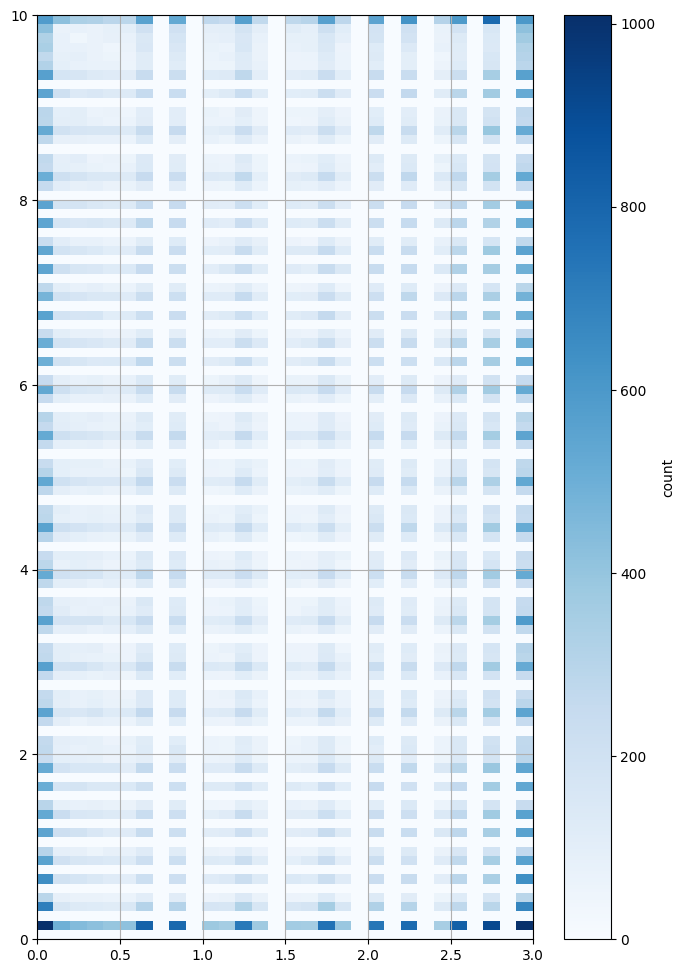

In [37]:
# 累積データ用のリスト
all_y = []

# for i in range(len(dm.test_dataset)):
for i in range(len(dm.train_dataset)):
    # バッチデータの取得
    # batch = dm.test_dataset[i]
    batch = dm.train_dataset[i]
    x, y = batch
    x = x.unsqueeze(0).cuda()
    y = y.unsqueeze(0).cuda()

    # 必要なデータをCPU上に戻す
    y = y.cpu().detach().numpy()

    # 累積データに追加
    all_y.append(y)

# 全データを結合
all_y = np.concatenate(all_y, axis=1)  # (1, 全座標数, 2)
print(all_y.shape)
print(all_y)

# XとYの範囲を指定（0.1刻み）
x_bins = np.arange(0, 3.1, 0.1)  # 0から3まで0.1刻み
y_bins = np.arange(0, 10.1, 0.1)  # 0から10まで0.1刻み

# 各座標ごとのカウント（2次元ヒストグラム）
counts, x_edges, y_edges = np.histogram2d(
    all_y[0, :, 0],  # x座標
    all_y[0, :, 1],  # y座標
    bins=[x_bins, y_bins]
)

# ヒートマップの描画
plt.figure(figsize=(8, 12))
plt.imshow(
    np.flipud(counts.T),  # Y軸を反転
    extent=[x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()],
    cmap='Blues',
    aspect='auto',
    origin='lower'
)
plt.colorbar(label='count')
plt.grid(True)
plt.show()